In [1]:
import os
import shutil
import tarfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATASET_ID   = '1p0CSRb9gax0sKqdyzOYVt-BXvZ4GtrBv'

# -------------BASE DIR (MODIFY THIS TO YOUR NEED) ------------ #
BASE_DIR     = '../Dataset/'

DATA_DIR     = 'Sensor-Data/'
BW_IMG_DIR   = 'BW-Spatial-Path-Images/'
RGB_IMG_DIR  = 'RGB-Spatial-Path-Images/'
IMG_SIZE     = (3, 3) # INCHES

USERS        = ['001', '002', '003', '004', '005', '006', '007', '008', '009',
                '010', '011', '012', '013', '014', '015', '016', '017', '018',
                '019', '020', '021', '022', '023', '024', '025']
# ------------------------------- Only Dynalic Gestures ------------------------------ #
GESTURES     = ['j', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
                'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

PLANES       = ['XY', 'YZ', 'ZX']

DT           = 0.01
SHAPES       = 100

In [3]:
#--------------------- Download util for Google Drive ------------------- #

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
        
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
        
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

def download_data(fid, destination):
    print('cleaning already existing files ... ', end='')
    try:
        shutil.rmtree(destination)
        print('√')
    except:
        print('✕')
        
    print('creating data directory ... ', end='')
    os.mkdir(destination)
    print('√')
    
    print('downloading dataset from the repository ... ', end='')
    filename = os.path.join(destination, 'dataset.tar.xz')
    try:
        download_file_from_google_drive(fid, filename)
        print('√')
    except:
        print('✕')
        
    print('extracting the dataset ... ', end='')
    try:
        tar = tarfile.open(filename)
        tar.extractall(destination)
        tar.close()
        print('√')
    except:
        print('✕')   

In [4]:
# ------- Comment This if already downloaded -------- #

destination = os.path.join(BASE_DIR, DATA_DIR)
download_data(DATASET_ID, destination)

cleaning already existing files ... ✕
creating data directory ... √
downloading dataset from the repository ... √
extracting the dataset ... √


In [6]:
# ------------- Spatial Path Image Generation ----------- #

def clean_dir(path):
    print('cleaning already existing files ... ', end='')
    try:
        shutil.rmtree(path)
        print('√')
    except:
        print('✕')
    
    print('creating ' + path + ' directory ... ', end='')
    os.mkdir(path)
    print('√')
    
# ----------- Spatial Path Vector Calculation ----------- #

def get_displacement(acc):
    v = np.zeros(acc.shape)
    d = np.zeros(acc.shape)
    for i in range(acc.shape[0] - 1):
        v[i + 1] = v[i] + acc[i] * DT
        d[i + 1] = v[i] * DT + 0.5 * acc[i] * DT * DT
        
    return d

def write_image(x, y, path):
    fig, ax = plt.subplots(frameon=True, figsize=(3, 3))
    ax.axis('off')
    plt.scatter(x, y, s=SHAPES, c='black')
    # plt.savefig(path)
    plt.show()

def generate_bw_images():
    count = 0
    image_dir = os.path.join(BASE_DIR, BW_IMG_DIR)
    clean_dir(image_dir)
    
    for plane in PLANES:
        print('processing spatial path images for ' + plane + ' plane ... ', end='')
        plane_dir = os.path.join(image_dir, plane)
        os.mkdir(plane_dir)
        
        for gesture in GESTURES:
            os.mkdir(os.path.join(plane_dir, gesture))
    
            for user in USERS:
                user_dir = os.path.join(BASE_DIR, DATA_DIR, user)
                gesture_dir = os.path.join(user_dir, gesture + '.csv')
                
                accx = pd.read_csv(gesture_dir)['ACCx'].to_numpy()
                accy = pd.read_csv(gesture_dir)['ACCy'].to_numpy()
                accz = pd.read_csv(gesture_dir)['ACCz'].to_numpy()

                x = get_displacement(accx).reshape(-1, 150)
                y = get_displacement(accy).reshape(-1, 150)
                z = get_displacement(accz).reshape(-1, 150)

                for i in range(x.shape[0]):
                    image_name = 'u' + user + '_g' + '{:0>2d}'.format(GESTURES.index(gesture)) + \
                                 '_s' + '{:0>7d}'.format(count) + '_p' + plane + '.jpg'
                    path = os.path.join(BASE_DIR, BW_IMG_DIR, plane, gesture, image_name)
                    
                    if plane == 'XY':
                        write_image(x[i, :], y[i, :], path)
                    elif plane == 'YZ':
                        write_image(y[i, :], z[i, :], path)
                    else:
                        write_image(z[i, :], x[i, :], path)

                    count = count + 1
            
        print('√')

In [6]:
generate_bw_images()

cleaning already existing files ... √
creating ../BW-Spatial-Path-Images/ directory ... √
processing spatial path images for XY plane ... √
processing spatial path images for YZ plane ... √
processing spatial path images for ZX plane ... √


cleaning already existing files ... ✕
creating ../Dataset/BW-Spatial-Path-Images/ directory ... √
processing spatial path images for XY plane ... 

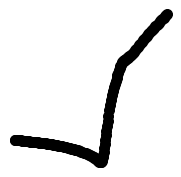

In [7]:
count = 0
image_dir = os.path.join(BASE_DIR, BW_IMG_DIR)
clean_dir(image_dir)

for plane in PLANES:
    print('processing spatial path images for ' + plane + ' plane ... ', end='')
    plane_dir = os.path.join(image_dir, plane)
    os.mkdir(plane_dir)
    
    for gesture in GESTURES:
        os.mkdir(os.path.join(plane_dir, gesture))

        for user in USERS:
            user_dir = os.path.join(BASE_DIR, DATA_DIR, user)
            gesture_dir = os.path.join(user_dir, gesture + '.csv')
            
            accx = pd.read_csv(gesture_dir)['ACCx'].to_numpy()
            accy = pd.read_csv(gesture_dir)['ACCy'].to_numpy()
            accz = pd.read_csv(gesture_dir)['ACCz'].to_numpy()

            x = get_displacement(accx).reshape(-1, 150)
            y = get_displacement(accy).reshape(-1, 150)
            z = get_displacement(accz).reshape(-1, 150)

            for i in range(x.shape[0]):
                image_name = 'u' + user + '_g' + '{:0>2d}'.format(GESTURES.index(gesture)) + \
                                '_s' + '{:0>7d}'.format(count) + '_p' + plane + '.jpg'
                path = os.path.join(BASE_DIR, BW_IMG_DIR, plane, gesture, image_name)
                
                if plane == 'XY':
                    write_image(x[i, :], y[i, :], path)
                elif plane == 'YZ':
                    write_image(y[i, :], z[i, :], path)
                else:
                    write_image(z[i, :], x[i, :], path)

                count = count + 1

                break
            break
        break
    break
        
    print('√')